In [1]:
import numpy as np

## 1.定义所需函数
**(1)sigmoid函数**
$$ g(z) = \frac{1}{1+e^{(-z)}} $$

In [2]:
def sigmoid(z):
    '''sigmoid函数'''
    return 1 / (1 + np.exp(-z))

**(2)sigmoid函数的导数**
$$ g'(z) = \frac{e^{-z}}{(1+e^{-z})^2} = \frac{1}{1+e^{-z}} \cdot \frac{e^{-z}}{1+e^{-z}} = g(z) \cdot (1-g(z)) $$
$ a^{(l)}_n $ 表示为第 $ l $ 层第 $ n $ 个激活值，即$ a^{(l)}_n = g(z^{(l)}_n) $ 

In [3]:
def sigmoidDerivative(a):
    '''
    对sigmoid函数求导，这里传入的是a值!
    a是一个array,表示的是第l层的所有激活值
    np.multiply()，向量或矩阵对应位置元素相乘，所得维度与原向量/矩阵相同
    '''
    return np.multiply(a, (1-a))

**(3)初始化权值矩阵** <br/>
&emsp;&emsp;初始化 $ \theta^{l}_{ji} $ <br/>
&emsp;&emsp;$ j $ 取值为 $ \{ 0,1,2,...,N_{(S^{l+1})}\} $ ， $ i $ 取值为 $ \{ 0,1,2,...,N_{(S^{l})}+ 1 \}$ <br/>
&emsp;&emsp;$ N_{S^{l}} $ 表示第l层神经元个数

In [4]:
def initThetas(hiddenNum, unitNum, inputSize, classNum, epsilon):
    '''
    初始化权值矩阵
    Args:
        hiddenNum : 隐藏层数
        unitNum : 每个隐藏层的神经元个数
        inputSize : 输入层规模
        classNum : 分类数目
        epsilon : 用来随机初始化权值
    Return:
        thetas : 权值矩阵
    '''
    
    hiddens = [unitNum for i in range(hiddenNum)]
    units = [inputSize] + hiddens + [classNum]
    # 例如：units = [3,4,4,3]
    thetas = []
    for idx, unit in enumerate(units):
        if idx == len(units) - 1:
            break
        nextUnit = units[idx + 1]
        
        theta = np.random.rand(nextUnit, unit+1) * 2 * epsilon - epsilon
        thetas.append(theta)
    return thetas

**(4)计算代价值函数**
$$ J(\theta) = - \frac{1}{m}[ \sum_{i=1}^m \sum_{k=1}^K y_k^{(i)} \log(h_\theta(x^{(i)}))_k + (1-y_k^{(i)})\log(1-h_\theta(x^{(i)}))_k]+ \frac{\lambda}{2m}\sum_{l=1}^{L-1} \sum_{i=1}^{S_l} \sum_{j=1}^{S_{l+1}} (\theta_{ji}^{(l)})^2 $$<br/>
此处的 $ y_k^{(i)} $ 是指对于第 $ i $ 个样本，分类为 $ k $ 的预测值 <br/><br/>
而 $ y^{(i)} $ 为向量 $ [y_1^{(i)},y_2^{(i)},...,y_K^{(i)}] $

In [5]:
def computeCost(thetas, y, theLambda, X=None, a=None):
    '''
    计算代价
    Args:
        thetas : 权值矩阵序列
        X : 样本
        y : 标签集
        a : 各层激活值
    Returns:
        J 预测代价
    '''
    # m为样本数
    m = y.shape[0]  
    if a is None:
        a = fp(thetas, X)
    
    # 注意，计算代价的时候，我们只需要关注整个网络的预测和标注之间的差异即可，
    # 因此只需要看a[-1]。
    # 另外一个注意点是：标注y已经被向量化了，有且仅有一位是1，其他都是0
    error = -np.sum(np.multiply(y.T,np.log(a[-1])) + np.multiply((1-y).T, np.log(1-a[-1])))
    
    # 正则化项,L2正则化
    reg = np.sum([np.sum(np.multiply(theta[:,1:],theta[:,1:])) for theta in thetas])
    return (1.0/m) * error + (1.0/(2*m)) * theLambda * reg
    

**（5）标签向量化、参数展开成向量、参数恢复成矩阵**

In [6]:
def adjustLabels(y):
    '''标签向量化

    Args:
        y : 标签集（数值类型：0,1,2，...,9;此例子时手写数字识别）
    Returns:
        yAdjusted : 向量化后的标签
    '''   
    if y.shape[1] == 1:
        # np.flatten()返回一份拷贝，对拷贝所做修改不会影响原始矩阵
        # 而np.ravel()返回的是视图，修改时会影响原始矩阵 
        classes = set(np.ravel(y))
        classNum = len(classes)
        minClass = min(classes)
        if classNum > 2: #多分类，使用向量标注，对应类别位置设置为1
            yAdjusted = np.zeros((y.shape[0], classNum), np.float64)
            for row, label in enumerate(y):
                yAdjusted[row, label - minClass] = 1.0
        else: # 二分类
            yAdjusted = np.zeros((y.shape[0], 1), np.float64)
            for row, label in enumerate(y):
                if label != minClass:
                    yAdjusted[row,0] = 1.0
    return yAdjusted            

In [7]:
def unroll(matrixes):
    '''
    参数展开
    Args:
        matrixes 矩阵
    Return:
        vec 向量
    '''
    
    vec = []
    for matrix in matrixes:
        vector = matrix.reshape(1,-1)[0]
        vec = np.concatenate((vec,vector))
    return vec

In [8]:
def roll(vector, shapes):
    '''
    参数恢复
    Args:
        vector 向量
        shapes shape list
    Returns:
        matrixes 恢复的矩阵序列    
    '''
    matrixes = []
    begin = 0
    for shape in shapes:
        end = begin + shape[0] * shape[1]
        matrix = vector[begin:end].reshape(shape)
        begin = end
        matrixes.append(matrix)
    return matrixes

**(6)前向反馈过程** <br/>
用来计算 $ a^l_i $ ，每一层的激活函数值 

In [9]:
def fp(theta, X):
    '''
    前向反馈过程
    Args:
        Thetas 权值矩阵
        X 输入样本
    Returns:
        a 各层激活向量
    '''
    # 计算层数layers = [0,1,2,3]
    layers = list(range(len(thetas) + 1))
    layerNum = len(layers)
    # 激活向量序列
    a = list(range(layerNum)) # 要的仅仅是定长list结构，内部元素在下面for循环中被赋值
    
    # 前向传播计算各层输出
    for l in layers:
        if l == 0: # 输入层, a即为输入值
            a[l] = X.T  # 特征值的排列是竖着的
        else:
            z = thetas[l - 1] * a[l - 1]
            a[l] = sigmoid(z)
        
        # 除输出层外，需要添加偏置
        if l != layerNum - 1:
            a[l] = np.concatenate((np.ones((1,a[l].shape[1])), a[l]))
    return a
                

**(7)反向传播过程** <br/>
用来计算权值梯度

In [10]:
def bp(thetas, a, y, theLambda):
    '''反向传播过程

    Args:
        a 激活值
        y 标签
    Returns:
        D 权值梯度
    '''
    m = y.shape[0]
    layers = list(range(len(thetas) + 1))
    layerNum = len(layers)
    d = list(range(len(layers)))
    delta = [np.zeros(theta.shape) for theta in thetas]
    
    for l in layers[::-1]: # 反向遍历层
        if l == 0:
            # 输入层不计算误差
            break
        if l == layerNum - 1:
            # 输出层误差
            d[l] = a[l] - y.T
        else:
            # 忽略偏置
            d[l] = np.multiply((thetas[l][:,1:].T * d[l + 1]), sigmoidDerivative(a[l][1:, :]))
            
    for l in layers[0:layerNum - 1]:
        delta[l] += d[l + 1] * (a[l].T)
    D = [np.zeros(theta.shape) for theta in thetas]
    for l in range(len(thetas)):
        theta = thetas[l]
        # 偏置更新增量
        D[l][:, 0] = (1.0 / m) * (delta[l][0:, 0].reshape(1, -1))
        # 权值更新增量
        D[l][:, 1:] = (1.0 / m) * (delta[l][0:, 1:] +
                                   theLambda * theta[:, 1:])
    return D

**(8)更新权值**

In [11]:
def updateThetas(m, thetas, D, alpha, theLambda):
    """更新权值

    Args:
        m 样本数
        thetas 各层权值矩阵
        D 梯度
        alpha 学习率
        theLambda 正规化参数
    Returns:
        Thetas 更新后的权值矩阵
    """
    for l in range(len(thetas)):
        thetas[l] = thetas[l] - alpha * D[l]
    return thetas

**(9)梯度下降**

In [12]:
def gradientDescent(thetas, X, y, alpha, theLambda):
    """梯度下降

    Args:
        X 样本
        y 标签
        alpha 学习率
        theLambda 正规化参数
    Returns:
        J 预测代价
        Thetas 更新后的各层权值矩阵
    """
    # 样本数，特征数
    m, n = X.shape
    # 前向传播计算各个神经元的激活值
    a = fp(thetas, X)
    # 反向传播计算梯度增量
    D = bp(thetas, a, y, theLambda)
    # 计算预测代价
    J = computeCost(thetas,y,theLambda,a=a)
    # 更新权值
    thetas = updateThetas(m, thetas, D, alpha, theLambda)
    if np.isnan(J):
        J = np.inf
    return J, thetas

**(10)梯度校验**

In [13]:
def gradientCheck(thetas,X,y,theLambda):
    """梯度校验

    Args:
        thetas 权值矩阵
        X 样本
        y 标签
        theLambda 正则化参数
    Returns:
        checked 是否检测通过
    """
    m, n = X.shape
    # 前向传播计算各个神经元的激活值
    a = fp(thetas, X)
    # 反向传播计算梯度增量
    D = bp(thetas, a, y, theLambda)
    # 计算预测代价
    J = computeCost(thetas, y, theLambda, a=a)
    DVec = unroll(D)
    
    # 数值化计算梯度
    epsilon = 1e-4 # 注意，这个epsilon的意义
    gradApprox = np.zeros(DVec.shape)
    ThetaVec = unroll(thetas)
    shapes = [theta.shape for theta in thetas]
    for i,item in enumerate(ThetaVec):
        ThetaVec[i] = item - epsilon
        JMinus = computeCost(roll(ThetaVec,shapes),y,theLambda,X=X)
        ThetaVec[i] = item + epsilon
        JPlus = computeCost(roll(ThetaVec,shapes),y,theLambda,X=X)
        gradApprox[i] = (JPlus-JMinus) / (2*epsilon)
        
    # 平均差距
    diff = np.average(gradApprox - DVec)
    #print 'gradient checking diff:', diff # 3.21615931121e-06
    if diff < 1e-5:
        return True
    else:
        return False

**(11)网络训练**<br/>
训练时进行迭代，计算最优参数

In [14]:
def train(X, y,checkFlag=False, thetas=None, hiddenNum=0, unitNum=5, epsilon=1, alpha=1, theLambda=0, precision=0.0001, maxIters=50):
    """网络训练

    Args:
        X 训练样本
        y 标签集
        checkFlag 是否进行梯度校验，默认为False，即不进行校验。梯度校验费时
        thetas 初始化的Thetas，如果为None，由系统随机初始化Thetas
        hiddenNum 隐藏层数目
        unitNum 隐藏层的单元数
        epsilon 初始化权值的范围[-epsilon, epsilon]
        alpha 学习率
        theLambda 正规化参数
        precision 误差精度
        maxIters 最大迭代次数
    """
    # 样本数，特征数
    m, n = X.shape
    # 标注标签向量化，比如多分类标签要转成向量
    y = adjustLabels(y)
    classNum = y.shape[1]
    # 初始化Theta
    if thetas is None:
        thetas = initThetas(
            inputSize=n,
            hiddenNum=hiddenNum,
            unitNum=unitNum,
            classNum=classNum,
            epsilon=epsilon
        )
        
    # 梯度校验
    print('Doing Gradient Checking....')
    if checkFlag:
        checked = gradientCheck(thetas, X, y, theLambda)
    else:
        checked=True
    print('Gradient Checked.')
    
    if checked:
        last_error = np.inf
        for i in range(maxIters):
            error, thetas = gradientDescent(
                thetas, X, y, alpha=alpha, theLambda=theLambda)
            if abs(error-last_error) < precision:
                last_error = error
                break
            if error == np.inf:
                last_error = error
                break
            last_error = error
        
        return {
            'error': error,
            'thetas': thetas,
            'iters': i
        }
    else:
        print('Error: Gradient Cheching Failed!!!')
        return {
            'error': None,
            'Thetas': None,
            'iters': 0
        }

**(12)预测函数**

In [15]:
def predict(X, thetas):
    """预测函数

    Args:
        X: 样本
        thetas: 训练后得到的参数
    Return:
        a
    """
    a = fp(thetas,X)
    return a[-1]

## 2.手写数字数据集

In [16]:
from scipy.io import loadmat
from matplotlib import pyplot
%matplotlib inline

In [17]:
data = loadmat('data/handwritten_digits.mat')

In [18]:
data['X'][0].shape

(400,)

[4]


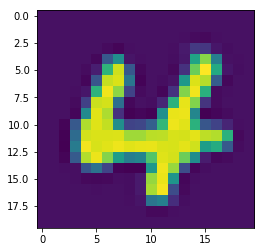

In [19]:
pyplot.imshow(data['X'][2200].reshape(20,20).T) # 因为mat数据存储的问题，需要转置一下
print(data['y'][2200])

In [20]:
X = np.mat(data['X'])
y = np.mat(data['y'])

In [21]:
thetas = loadmat('data/init_weights.mat')
thetas = [thetas['Theta1'], thetas['Theta2']]

In [22]:
res = train(X,y,checkFlag=False, hiddenNum=1,unitNum=25,thetas=thetas,maxIters=500)

Doing Gradient Checking....
Gradient Checked.


In [23]:
res['iters'], res['error']

(499, 0.19417985808360613)

In [27]:
def readable_predict(idx, X, thetas):
    print('predict:', (np.argmax(predict(X[idx], thetas))+1)) # 网络的标签从0开始
    print('real tag:', y[idx].ravel()) # 真实的标签把0标记成了10
    pyplot.imshow(X[idx].reshape(20,20).T)

predict: 10
real tag: [[10]]


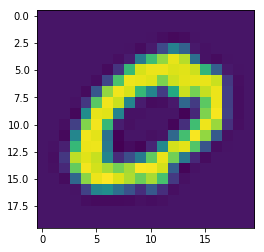

In [31]:
readable_predict(235, X, res['thetas'])